In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from fastai import *
from fastai.vision import *
import pretrainedmodels
from fastai.callbacks.tracker import *
from fastai.callbacks.hooks import *
from torch.utils.data import Sampler, BatchSampler
import json

from utils import *

The below is useful if you would like to get updates in your notebook on training as you would in console.

My workflow is -> fire up an instance -> start jupyter notebook in tmux -> start training -> disconnect

(this gives you one update per epoch - with the regular progress bar chances are you will hit a time out before all the updates that were buffered get forwarded to your browser upon reconnection)

In [ ]:
# import fastai
# from fastprogress import force_console_behavior
# import fastprogress
# fastprogress.fastprogress.NO_BAR = True
# master_bar, progress_bar = force_console_behavior()
# fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar

In [2]:
PATH = Path('data/txt')

###  Create ImageDataBunch using the data block API

In [3]:
sz_lrg, sz_small = 192, 96
bs = 520

In [4]:
batch_stats_lrg = pd.read_pickle(f'data/batch_stats_{sz_lrg}.pkl')
batch_stats_lrg = batch_stats_lrg[0][:, None, None], batch_stats_lrg[1][:, None, None]

batch_stats_small = pd.read_pickle(f'data/batch_stats_{sz_small}.pkl')
batch_stats_small = batch_stats_small[0][:, None, None], batch_stats_small[1][:, None, None]

country2code = {v: k for k, v in enumerate(pd.read_pickle('data/countrycodes.pkl'))}
codes_count = len(country2code); codes_count

218

In [5]:
seq_max_len = 68

def create_func(path):
    with open(path) as f: j = json.load(f)
    
    drawing_lrg = list2drawing(j['drawing'], size=sz_lrg, time_color=True)
    tensor_lrg = drawing2tensor(drawing_lrg)
    tensor_lrg.div_(255).sub_(batch_stats_lrg[0]).div_(batch_stats_lrg[1])
    
    drawing_small = list2drawing(j['drawing'], size=sz_small, time_color=True)
    tensor_small = drawing2tensor(drawing_small)
    tensor_small.div_(255).sub_(batch_stats_small[0]).div_(batch_stats_small[1])
    
    ary = drawing2seq(j['drawing'])
    seq = np.zeros((seq_max_len, 3))
    seq[-ary.shape[0]:, :] = ary[:seq_max_len, :]
    
    country_code = country2code[j['countrycode']] if j['countrycode'] in country2code.keys() else 0
    return tensor_lrg, tensor_small, seq.astype(np.float32), country_code

In [6]:
%%time
item_list = ItemList.from_folder(PATH/'train', create_func=create_func)
item_lists = item_list.random_split_by_pct(0.002, seed=0)

CPU times: user 10min 2s, sys: 4min 58s, total: 15min 1s
Wall time: 20min 14s


In [8]:
# label_lists = item_lists.label_from_folder()
# pd.to_pickle(label_lists.train.y.classes, 'data/classes.pkl')

In [9]:
classes = pd.read_pickle('data/classes.pkl')

label_lists = item_lists.label_from_folder(classes=classes)

test_items = ItemList.from_folder(PATH/'test', create_func=create_func)
label_lists.add_test(test_items);

In [10]:
train_dl = DataLoader(
    label_lists.train,
    num_workers=64,
    batch_sampler=BatchSampler(RandomSamplerWithEpochSize(label_lists.train, 200_000), bs, True)
)
valid_dl = DataLoader(label_lists.valid, bs, False, num_workers=12)
test_dl = DataLoader(label_lists.test, bs, False, num_workers=12)

data_bunch = ImageDataBunch(train_dl, valid_dl, test_dl)

### Train

In [11]:
name = 'resnet50-incv4'

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, c_in, c_out, k):
        super().__init__()
        self.conv = nn.Conv1d(c_in, c_out, k)
        self.bn = nn.BatchNorm1d(c_out)
    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        x = self.bn(x)
        return x

class RNNBlock(nn.Module):
    def __init__(self, inp_sz, hidden_sz=128, num_l=1, bi=False, last_h=False):
        super().__init__()
        self.rnn = nn.LSTM(input_size=inp_sz, hidden_size=hidden_sz, num_layers=num_l, bidirectional=bi)
        self.last_h = last_h
    def forward(self, x):
        x = self.rnn(x)[0]
        if self.last_h: x = x[-1]
        x = F.relu(x)
        return x

cnn_lstm = nn.Sequential(*[
    Lambda(lambda x: x.transpose(2,1)),
    ConvBlock(3, 48, 5),
    ConvBlock(48, 64, 5),
    ConvBlock(64, 96, 5),
    Lambda(lambda x: x.permute(2,0,1)),
    RNNBlock(96),
    RNNBlock(128, last_h=True),
    Lambda(lambda x: x.squeeze()),
])

In [13]:
COUNTRY_EMB_SZ = 20

class MixedInputModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_lrg = nn.Sequential(create_body(models.resnet50(True), -2), nn.AdaptiveAvgPool2d(1))
        self.conv_small = create_body(pretrainedmodels.inceptionv4(), -2)
        self.cnn_lstm = cnn_lstm
        self.country_emb = nn.Embedding(codes_count, COUNTRY_EMB_SZ)
        head_inp_sz = num_features_model(self.conv_lrg) + \
            model_sizes(self.conv_small, (96, 96), False)[-1][1] + self.country_emb.embedding_dim + cnn_lstm[6].rnn.hidden_size
#         self.head = create_head(head_inp_sz, 340)[2:]
        self.head = create_head(head_inp_sz, 340, ps=0, lin_ftrs=[4000, 2000])[2:]
        
    def forward(self, drawings_lrg, drawings_small, seqs, country_codes):
        x = torch.cat(
            (
                self.conv_lrg(drawings_lrg).squeeze(),
                self.conv_small(drawings_small).squeeze(),
                self.cnn_lstm(seqs.float()),
                self.country_emb(country_codes)
            ),
            -1
        )
        return self.head(x)

In [30]:
learn = Learner(data_bunch, MixedInputModel(), metrics=[accuracy, map3])

In [31]:
learn.model = nn.DataParallel(learn.model)

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


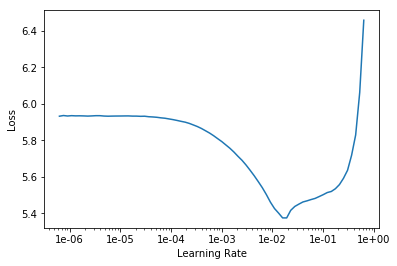

In [19]:
learn.recorder.plot()

... did some training here ...

### Replacing the classifier

Freezing your arch can be very helpful for trying out a new classifier (head)! As it turned out, with a bigger classifer, I jumped 100 spots on the public LB!

(cnn_lstm etc are submodules of module which is added through DataParallel)

In [42]:
state_dict = torch.load('models/resnet50-incv4-2e-05.pth')

In [53]:
keys = list(state_dict.keys())

In [54]:
for k in keys:
    if 'module.head' in k: del state_dict[k]

At this point I modify the architecture above and rerun the cells. I have the state_dict ready so all I need is to load it.

(the weights in the lower level of the model have been retained - I will need to train the classifier from scratch, it has been reinitialized with random weights)

In [56]:
learn.model.load_state_dict(state_dict, False)

Freezing submodules

In [59]:
for m in [learn.model.module.cnn_lstm, learn.model.module.conv_lrg, learn.model.module.conv_small]:
    requires_grad(m, False)

In [60]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


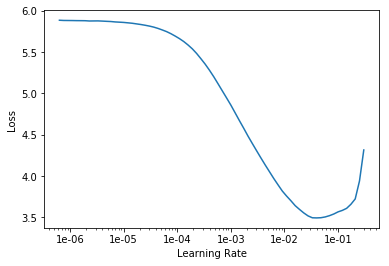

In [61]:
learn.recorder.plot()

In [62]:
learn.fit_one_cycle(4, 5e-3)

Total time: 32:31
epoch  train_loss  valid_loss  accuracy  map3     
1      0.997846    9271.355469  0.744080  0.812822  (08:08)
2      0.858220    1105.838989  0.777960  0.840417  (08:07)
3      0.696471    2100.821289  0.796980  0.852824  (08:06)
4      0.520798    1567.136353  0.805950  0.859583  (08:08)



And then I unfreeze the whole model and resume training...

### Making changes to batch norm

Maybe you might have a need to stop tracking runnining mean an sd in your batchnorm layers - here is how to do it. You can also update the momentum with which stats are tracked in similar fashion.

In [65]:
for l in flatten_model(learn.model):
    if type(l) == nn.BatchNorm1d or type(l) == nn.BatchNorm2d:
        l.track_running_stats = False

There can be a situation in which the activations of your model change quickly enough where the running stats just cannot keep up. Take a look below:

In [87]:
learn.fit(1, 5e-4)

Total time: 10:28
epoch  train_loss  valid_loss  accuracy  map3    
1      0.520851    143.771622  0.802850  0.858103  (10:28)



The validation loss does not track the train loss (often the accuracy will also be affected).

There are no hard rules to follow here, the point is that you might run into a situation such as this and there is no reason to be too concerned.

In general, this should go away once you start training with a lower learning rate.

There is quite a bit of information online (predominantly on pytorch forums) that you can look up if you do encounter this scenario or should the problem not go away on its own.

One other think to note here - the default value of momentum in pytorch for a batchnorm layer is 0.9 and 0.99 in keras. As this has an exponential effect on how stats are accumulated, this can make quite a big difference.

### Predict

In [49]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

Downloading some of the preds as I thought I might continue working on this on another machine

In [59]:
from IPython.display import FileLink
FileLink('preds/test_preds')

/home/radek/quickdraw/preds/test_preds

In [55]:
create_submission(preds, data_bunch.test_dl, name, classes)

In [56]:
pd.read_csv(f'subs/{name}.csv.gz').head()

,key_id,word
0,9982748469652562,rollerskates roller_coaster tractor
1,9730298586740955,drill screwdriver megaphone
2,9495303600236565,matches paintbrush asparagus
3,9076379423232894,saxophone clarinet trombone
4,9278326467147683,The_Mona_Lisa face mermaid


In [57]:
!kaggle competitions submit -c quickdraw-doodle-recognition -f subs/{name}.csv.gz -m "{name}"

100%|██████████████████████████████████████| 1.50M/1.50M [00:00<00:00, 6.02MB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge